In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from scipy import io, sparse
import numpy as np

from pathlib import Path

In [3]:
base_dir = Path().resolve()
parent_dir = base_dir.parent
parent_dir

PosixPath('/home/sadegh/projects/nanostring-cosmx-spatial-omics-modeling')

# Read Converted R data and Make AnnData for All Tissue Micro Array

In [4]:
data_dir = parent_dir / 'data/converted_files_to_python_readable'
data_dir

PosixPath('/home/sadegh/projects/nanostring-cosmx-spatial-omics-modeling/data/converted_files_to_python_readable')

In [6]:
adatas = []
keys = []
for subdir in sorted(data_dir.iterdir()):
    if subdir.is_dir():
        mtx_file = subdir / "counts.mtx"
        if not mtx_file.exists():
            print(f"Skipping {subdir}, counts.mtx not found")
            continue

        print(f"Reading {mtx_file}")
        # Read MTX and convert to CSR (cells x genes)
        X = io.mmread(mtx_file).T.tocsr()  

        # Read gene names
        genes_file = subdir / "genes.csv"
        var = None
        if genes_file.exists():
            var = pd.read_csv(genes_file)
            var = var.rename(columns={"x": "gene"})

        # Read cell type data
        cell_file = subdir / "cluster_identities.csv"
        cell = None
        if cell_file.exists():
            cell = pd.read_csv(cell_file, index_col=0, low_memory=False)
            cell = cell.rename(columns={"x": "cell_type"})


        # Read cell metadata
        obs_file = subdir / "meta_data.csv"
        obs = None
        if obs_file.exists():
            obs = pd.read_csv(obs_file, index_col=0, low_memory=False)

        obs = pd.merge(obs, cell, left_index=True, right_index=True, how="inner")

        # Read spatial coords
        spatial = None
        cell_spatial_file = subdir / "spatial_coords.csv"
        if cell_spatial_file.exists():
            spatial = pd.read_csv(cell_spatial_file, index_col=0)
            spatial.index = spatial["cell"].astype(str) 
            spatial = spatial.drop(columns="cell")
            spatial = spatial.groupby("cell")[["x", "y"]].mean()

       

        # Create AnnData
        adata = sc.AnnData(X=X, obs=obs, var=var)
        if spatial is not None:
            adata.obsm["spatial"] = spatial.loc[adata.obs_names].values

        adatas.append(adata)
        keys.append(subdir.name)
        

Reading /home/sadegh/projects/nanostring-cosmx-spatial-omics-modeling/data/converted_files_to_python_readable/TMA1_minimal/counts.mtx
Reading /home/sadegh/projects/nanostring-cosmx-spatial-omics-modeling/data/converted_files_to_python_readable/TMA2_minimal/counts.mtx
Reading /home/sadegh/projects/nanostring-cosmx-spatial-omics-modeling/data/converted_files_to_python_readable/TMA3_minimal/counts.mtx
Reading /home/sadegh/projects/nanostring-cosmx-spatial-omics-modeling/data/converted_files_to_python_readable/TMA4_minimal/counts.mtx


In [7]:
adatas

[AnnData object with n_obs × n_vars = 636692 × 1011
     obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'id', 'TMA', 'Subject_ID', 'Treatment_Status', 'Run_Tissue_name', 'log10totalcounts', 'cell_type'
     var: 'gene'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 545852 × 1011
     obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'id', 'tissue', 'Subject_ID', 'Treatment_Status', 'Run_Tissue_name', 'log10totalcounts', 'cell_type'
     var: 'gene'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 860543 × 1011
     obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 

In [8]:
all_TMA = sc.concat(adatas, keys=keys, label="sample", index_unique="_", join="outer", merge="first")
all_TMA

AnnData object with n_obs × n_vars = 2873892 × 1011
    obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'id', 'TMA', 'Subject_ID', 'Treatment_Status', 'Run_Tissue_name', 'log10totalcounts', 'cell_type', 'tissue', 'sample'
    var: 'gene'
    obsm: 'spatial'

In [9]:
print(f"Merged shape: {all_TMA.shape}")
all_TMA.write("merged_TMA.h5ad", as_dense="X")

Merged shape: (2873892, 1011)


# Read all TMA dataset and Process it

In [10]:
adata = sc.read(parent_dir / "data/h5ad/merged_TMA.h5ad")
adata

AnnData object with n_obs × n_vars = 2873892 × 1011
    obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'id', 'TMA', 'Subject_ID', 'Treatment_Status', 'Run_Tissue_name', 'log10totalcounts', 'cell_type', 'tissue', 'sample'
    var: 'gene'
    obsm: 'spatial'

In [11]:
# Distribution of Cell per Status
counts = adata.obs.groupby(["Subject_ID", "Treatment_Status"]).size().unstack(fill_value=0)
counts

Treatment_Status,Treated,Untreated
Subject_ID,,
78410A1,0,167909
89397,144507,0
92604,146228,0
95278A2,0,28264
114262,23329,0
118223A,0,126455
120136,50073,0
120139,0,116827
120140,0,114029


In [ ]:
# adata.var.to_csv('gene_name.csv', header=False, index=False)

In [ ]:
adata.X

In [12]:
total_elements = adata.shape[0] * adata.shape[1] 
# nonzero = adata.X.nnz                    
nonzero = np.count_nonzero(adata.X)
zero = total_elements - nonzero                  
sparsity = zero / total_elements * 100           

print(f"🔢 Total elements     : {total_elements:,}")
print(f"✅ Non-zero elements : {nonzero:,}")
print(f"⭕️ Zero elements     : {zero:,}")
print(f"📉 Sparsity          : {sparsity:.2f}% zeros")


🔢 Total elements     : 2,905,504,812
✅ Non-zero elements : 273,389,699
⭕️ Zero elements     : 2,632,115,113
📉 Sparsity          : 90.59% zeros


### QC on anndata

In [13]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

### Filtering on cells and genes

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0.4)

In [14]:
if sparse.issparse(adata.X):
    genes_per_cell = np.array((adata.X > 0).sum(axis=1)).flatten()
else:
    genes_per_cell = (adata.X > 0).sum(axis=1)

In [15]:
median_nonzero = np.median(genes_per_cell)
mean_nonzero = np.mean(genes_per_cell)
print("Mean number of non-zero genes per cell:", mean_nonzero)
print("Median number of non-zero genes per cell:", median_nonzero)

Mean number of non-zero genes per cell: 95.12873100311354
Median number of non-zero genes per cell: 78.0


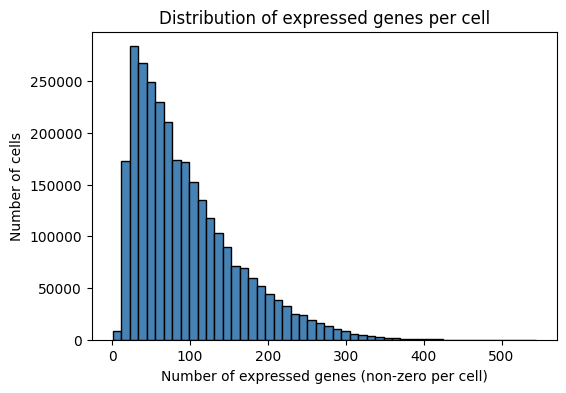

In [16]:
plt.figure(figsize=(6,4))
plt.hist(genes_per_cell, bins=50, color="steelblue", edgecolor="black")
plt.xlabel("Number of expressed genes (non-zero per cell)")
plt.ylabel("Number of cells")
plt.title("Distribution of expressed genes per cell")
plt.show()

In [17]:
print("Before filtering:", adata.shape)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
print("After filtering:", adata.shape)

Before filtering: (2873892, 1011)
After filtering: (242061, 1011)


### Normalization and Logarithmic Data

In [18]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

### Finding Highly Variable Genes

In [ ]:
# sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
# adata = adata[:, adata.var["highly_variable"]]
# adata

### Standardization data

In [19]:
sc.pp.scale(adata, max_value=10)

### Apply PCA - Dimensional Reduction

In [20]:
sc.tl.pca(adata, svd_solver="arpack")

### Neighborhood graph 

In [21]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

### Apply UMAP - Dimensional Reduction

In [22]:
sc.tl.umap(adata)

### Clustering by Leiden method

In [23]:
sc.tl.leiden(adata, resolution=0.5)

In [ ]:
adata

### Save Processed Dataset

In [24]:
adata.write(parent_dir / "data/h5ad/merged_TMA_processed_compatible_n_gene_200.h5ad", as_dense="X")

# Read Processed TMA dataset, Store as CSV and some Visualization

In [ ]:
adata = sc.read(parent_dir / 'merged_TMA_processed_compatible.h5ad')

In [ ]:
adata

In [ ]:
counts_df = pd.DataFrame(
        adata.X,
        index=adata.obs_names,
        columns=adata.var.gene
    )
counts_df.T

In [ ]:
# counts_df.to_csv('merged_TMA_preprocessed.csv')

### PCA and UMAP

In [ ]:
sc.pl.pca(
    adata,
    color=["leiden"],
    legend_loc="on data",
    frameon=False,
    size=2.0,
    wspace=0.3,
    save="_umap_leiden.png"  
)

In [ ]:
sc.pl.umap(
    adata,
    color=["leiden"],
    legend_loc="on data",
    frameon=False,
    size=2.0,
    wspace=0.3,
    save="_umap_leiden.png"  
)

### Plot Spatial coords based on leiden cluster

In [ ]:
# sc.pl.spatial(
#     adata,
#     color="leiden",
#     spot_size=100,     
#     frameon=False,
#     alpha_img=0.0,
#     save="_spatial_leiden.png" 
# )

### QC and Cell Compostion

In [ ]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_in_top_50_genes"],
    groupby="sample",
    jitter=0.4,
    multi_panel=True
)

In [ ]:
adata.obs["leiden"].value_counts().plot(kind="bar", figsize=(6,3))

### UMAP Visualization

In [ ]:
sc.pl.umap(adata, color="leiden", legend_loc="on data", frameon=False)

In [ ]:
sc.pl.umap(adata, color=["sample", "Treatment_Status"], frameon=False)

### Spatial Visualization

In [ ]:
sc.pl.embedding(
    adata,
    basis="spatial",
    color="leiden",
    frameon=False,
    size=3
)


#### per Tissue Sample

In [ ]:
# Per Sample
for s in adata.obs["sample"].unique():
    sc.pl.embedding(
        adata[adata.obs["sample"] == s],
        basis="spatial",
        color="leiden",
        frameon=False,
        size=3,
        title=f"Spatial - {s}"
    )

### PCA Visualization

In [ ]:
sc.pl.pca(adata, color="leiden")

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

### Cluster Relationship 

In [ ]:
sc.tl.dendrogram(adata, groupby="leiden")
sc.pl.dendrogram(adata, groupby="leiden")

In [ ]:
sc.tl.paga(adata, groups="leiden")
sc.pl.paga(adata, threshold=0.03, show=True)